In [2]:
##############################################################
# NbIT functions to calculate total inter-correlation coefficient
# via summing entropy over every ATOM, instead of RESIDUE.
# May not be compatible with other NbIT measurements.
# For formulae of all the functions, refer to:
#
# "Spontaneous Inward Opening of the Dopamine Transporter Is 
# Triggered by PIP2‐Regulated Dynamics of the N‐Terminus"
# Khelashvili et al. ACS Chemical Neuroscience (2015)
# 
# Hao Wu, Ph.D.
# Prof. Harel Weinstein's lab
# Weill Cornell Medicine
# haw4005@med.cornell.edu
# Last Updated: Sep 02 2021
##############################################################

##############################################################
# DEFINE FUNCTIONS
##############################################################

import MDAnalysis as mda
import numpy as np
#import matplotlib.pyplot as plt
from math import pi, log
#import pandas as pd

# Compute COV matrix in a sliding window manner
def compute_cov_matrix_sliding_window(atoms, atoms_ref, win_start, win_end, nsteps):
    p0 = atoms_ref.positions
    p0.shape
    # Compute the distance matrices
    N = (win_end-win_start)//nsteps
    dist_matrix = np.empty((p0.shape[0], nsteps, N))
    for n in range(N):
        for ts in u.trajectory[n*nsteps+win_start:(n+1)*nsteps+win_start]:
            dist_matrix[:, ts.frame-nsteps*n-win_start, n] = np.linalg.norm(atoms.positions-p0, axis = -1)[:]
    # Compute covariance matrix
    cov1 = np.empty((p0.shape[0], p0.shape[0], N))
    for n in range(N):
        cov1 [:, :, n] = np.cov(dist_matrix[:, :, n], rowvar=True)
    # Compute the averaged covariance matrix
    COV = np.average(cov1, axis = -1)
    return COV

def entropy(i):
    # i: atom indices in original trajectory
    # j: atom indices in a trajectory excluding hydrogen atoms, equals the first two dimensions of COV matrix
    j = np.where(np.in1d(atoms_ref.ids.tolist(), i)==True)[0].tolist()
    # if len(j)>1: H is the entropy of a site containing more than one atom
    if len(j)>1:
        H = 0.5*len(j)*(1+log(2*pi))+0.5*np.linalg.slogdet(np.take(np.take(COV, j, axis = 0), j, axis = -1))[1]
        return H
    # if len(j)==1: H is the entropy of a single-atom site
    elif len(j)==1:
        H = 0.5*len(j)*(1+log(2*pi))+0.5*log(np.take(np.take(COV, j, axis = -1), j, axis = 0))
        return H
    else:
        return print('Wrong index format or no elements in the list were found')

# total correlation: sum H over every atom
def total_correlation_by_atom(i):
    sum_H = 0
    for atom_id in i:
        sum_H += entropy(atom_id)
    H = entropy(i)
    return sum_H - H

def conditional_entropy(i, j):
    k = np.setdiff1d(i, j, assume_unique=True)
    Hij = entropy(np.hstack((k, j)))
    Hj = entropy(j)
    return Hij - Hj

def conditional_total_correlation_by_atom(i, j):
    i = np.setdiff1d(i, j, assume_unique=True).tolist()
    sum_H = 0
    for atom_id in i:
        sum_H += conditional_entropy(atom_id, j)
    H = conditional_entropy(i, j)
    return sum_H - H

def total_inter_correlation_by_atom(i, j):
    k = np.hstack((i, j)).tolist()
    return (total_correlation_by_atom(k) - conditional_total_correlation_by_atom(i, j) - conditional_total_correlation_by_atom(j, i))

def total_inter_correlation_coeff_by_atom(i, j):
    # dimension = total # of atoms in i and j minus 1
    scaling_coeff = len(i) + len(j) - 1 
    exp_part = np.exp(-2*total_inter_correlation_by_atom(i, j)/scaling_coeff)
    return np.sqrt(1 - exp_part)

In [4]:
##############################################################
# LOAD TRAJECTORY AND DEFINE SITES
##############################################################

# Load the trajectory assuming it is already aligned
# by Ambrose's autoalign code: https://github.com/weinsteinlab/Auto-align
u = mda.Universe('/Users/edk4002/Creative Cloud Files/NbIT_data/cut.psf',
                 '/Users/edk4002/Creative Cloud Files/NbIT_data/all.dcd')
# Load the reference structure
u_ref = mda.Universe('/Users/edk4002/Creative Cloud Files/NbIT_data/cut.psf', 
                     '/Users/edk4002/Creative Cloud Files/NbIT_data/cut.pdb')

total_n_frames = u.trajectory.n_frames

# Select the regions for NbIT
# DBS: dimeric binding site, residues within 4 angstroms of ligand in at least 40% of the large subset 
# Select the regions for NbIT
S1 = u.select_atoms('(segid LIG and resid 519) or (segid PROT and resid 25 26 104 108 253 254 256 259 355 359) or (segid INT and resid 517) and not type H')
NA1 = u.select_atoms('(segid INT and resid 517) or (segid PROT and resid 22 27 254 286) or (segid LIG and resid 519) and not type H')
NA2 = u.select_atoms('(segid INT and resid 516) or (segid PROT and resid 20 23 351 354 355) and not type H')
S2 = u.select_atoms('(segid PROT and resid 29 30 107 111 114 253 319 320 324 400 404) and not type H')
INI = u.select_atoms('(segid PROT and resid 5 187 267 268 361 369) and not type H')

# Select combinations of regions for the analysis
COMB = [S1, S2, NA1, NA2, NA1+NA2, NA1+NA2+S1, NA1+NA2+S1+S2, INI]
names = ['S1', 'S2', 'NA1', 'NA2', 'NA1+NA2', 'NA1+NA2+S1', 'NA1+NA2+S1+S2', 'INI']

# Select the atoms for covariance matrix calculations
atoms = u.select_atoms('not type H')
atoms_ref = u_ref.select_atoms('not type H')

In [7]:
##############################################################
# CALCULATE TIC COEFFICIENT IN SLIDING WINDOWS
##############################################################

# Define window size and separation
win_size = 1000 # 40 ns
win_separation = 100 # 10 ns 
# Set the number of steps in for covariance matrix averaging frame (<= win_size)
nsteps = win_size
win_num = 0
for win_start in np.arange(0, total_n_frames, win_separation):
    win_end = win_start+win_size
    if win_end > total_n_frames:
        break
    else:
        win_num += 1 

site0 = COMB[0].ids.tolist()
site1 = COMB[1].ids.tolist()
site2 = COMB[2].ids.tolist()

win_start_series = np.zeros(win_num)
TIC_coeff1 = np.zeros(win_num)
TIC_coeff2 = np.zeros(win_num)

i = 0
for win_start in np.arange(0, total_n_frames, win_separation):
    win_end = win_start+win_size
    if win_end > total_n_frames:
        break

    win_start_series[i] = win_start

    #print("Sliding window {} - {}:".format(win_start, win_end))
    COV = compute_cov_matrix_sliding_window(atoms, atoms_ref, win_start, win_end, nsteps)

    TIC_coeff1[i] = total_inter_correlation_coeff_by_atom(site0, site1)
    #print("DBS-OR_apo TIC coeff = {:.4f}".format(TIC_coeff1[i]))

    TIC_coeff2[i] = total_inter_correlation_coeff_by_atom(site0, site2)
    #print("DBS-OR_holo TIC coeff = {:.4f}".format(TIC_coeff2[i]))

    i += 1
    
#file1 = "./TIC_coeff_DBS_OR_apo_OR_holo.txt"
#np.savetxt(file1, np.c_[win_start_series, TIC_coeff1, TIC_coeff2], 
#    fmt=["%d", "%.4f", "%.4f"], header="win_start DBS-OR_apo DBS-OR_holo")

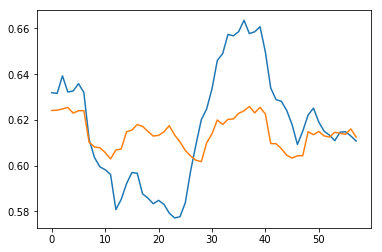

In [12]:
import matplotlib.pyplot as plt
plt.plot(TIC_coeff1)
plt.plot(TIC_coeff2)

In [4]:
##############################################################
# CALCULATE TIC COEFFICIENT IN THE ENTIRE TRAJECTORY
##############################################################

win_start = 0
win_end = total_n_frames
nsteps = win_end - win_start
COV = compute_cov_matrix_sliding_window(atoms, atoms_ref, win_start, win_end, nsteps)

site0 = DBS.ids.tolist()
site1 = OR_apo.ids.tolist()
site2 = OR_holo.ids.tolist()
site3 = D1_A.ids.tolist()
site4 = D2_A.ids.tolist()
site5 = D3_A.ids.tolist()
site6 = D1_B.ids.tolist()
site7 = D2_B.ids.tolist()
site8 = D3_B.ids.tolist()

TIC_coeff1 = total_inter_correlation_coeff_by_atom(site0, site1)
print("DBS-OR_apo TIC coeff = {:.4f}".format(TIC_coeff1))

TIC_coeff2 = total_inter_correlation_coeff_by_atom(site0, site2)
print("DBS-OR_holo TIC coeff = {:.4f}".format(TIC_coeff2))

TIC_coeff3 = total_inter_correlation_coeff_by_atom(site0, site3)
print("DBS-D1_A TIC coeff = {:.4f}".format(TIC_coeff3))

TIC_coeff4 = total_inter_correlation_coeff_by_atom(site0, site4)
print("DBS-D2_A TIC coeff = {:.4f}".format(TIC_coeff4))

TIC_coeff5 = total_inter_correlation_coeff_by_atom(site0, site5)
print("DBS-D3_A TIC coeff = {:.4f}".format(TIC_coeff5))

TIC_coeff6 = total_inter_correlation_coeff_by_atom(site0, site6)
print("DBS-D1_B TIC coeff = {:.4f}".format(TIC_coeff6))

TIC_coeff7 = total_inter_correlation_coeff_by_atom(site0, site7)
print("DBS-D2_B TIC coeff = {:.4f}".format(TIC_coeff7))

TIC_coeff8 = total_inter_correlation_coeff_by_atom(site0, site8)
print("DBS-D3_B TIC coeff = {:.4f}".format(TIC_coeff8))

f = open("./TIC_entire_traj_test.txt", "w")
f.write("OR_apo {:.4f}\n".format(TIC_coeff1))
f.write("OR_holo {:.4f}\n".format(TIC_coeff2))
f.write("D1_A {:.4f}\n".format(TIC_coeff3))
f.write("D2_A {:.4f}\n".format(TIC_coeff4))
f.write("D3_A {:.4f}\n".format(TIC_coeff5))
f.write("D1_B {:.4f}\n".format(TIC_coeff6))
f.write("D2_B {:.4f}\n".format(TIC_coeff7))
f.write("D3_B {:.4f}\n".format(TIC_coeff8))
f.close()

DBS-OR_apo TIC coeff = 0.5266
DBS-OR_holo TIC coeff = 0.5623
DBS-D1_A TIC coeff = 0.3640
DBS-D2_A TIC coeff = 0.3586
DBS-D3_A TIC coeff = 0.4217
DBS-D1_B TIC coeff = 0.3288
DBS-D2_B TIC coeff = 0.3853
DBS-D3_B TIC coeff = 0.4524
